In [48]:
import os
import uproot
import vector
import awkward as ak
import matplotlib.pylab as plt
import numpy as np

vector.register_awkward()

Let's look at this dataset:
[DoubleEG data](https://opendata.cern.ch/record/30554)


See here to learn what variables are in the event and what they mean:
[dataset semantics](https://opendata.cern.ch/eos/opendata/cms/dataset-semantics/NanoAOD/30554/DoubleEG_doc.html)

In [49]:
datafile_name = 'FB3ADF2F-FE4D-0944-A100-FA1D03041D4F.root'

if not (os.path.isfile(datafile_name)): 
    ! curl -O http://opendata.cern.ch/eos/opendata/cms/Run2016H/DoubleEG/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2500000/FB3ADF2F-FE4D-0944-A100-FA1D03041D4F.root

We'll use [uproot](https://github.com/scikit-hep/uproot5) for I/O 

In [50]:
infile = uproot.open(datafile_name)

In [51]:
events = infile['Events']
#events.show()

Let's read the data into [awkward](https://github.com/scikit-hep/awkward) arrays, filtering on electon-related variables:

In [52]:
df = events.arrays(filter_name='*Electron*', library='ak') 

In [53]:
df

<Array [{nElectron: 0, ...}, {...}, ..., {...}] type='219773 * {nElectron: ...'>

Let's plot a few variables:

Text(0.5, 0, 'electron eta')

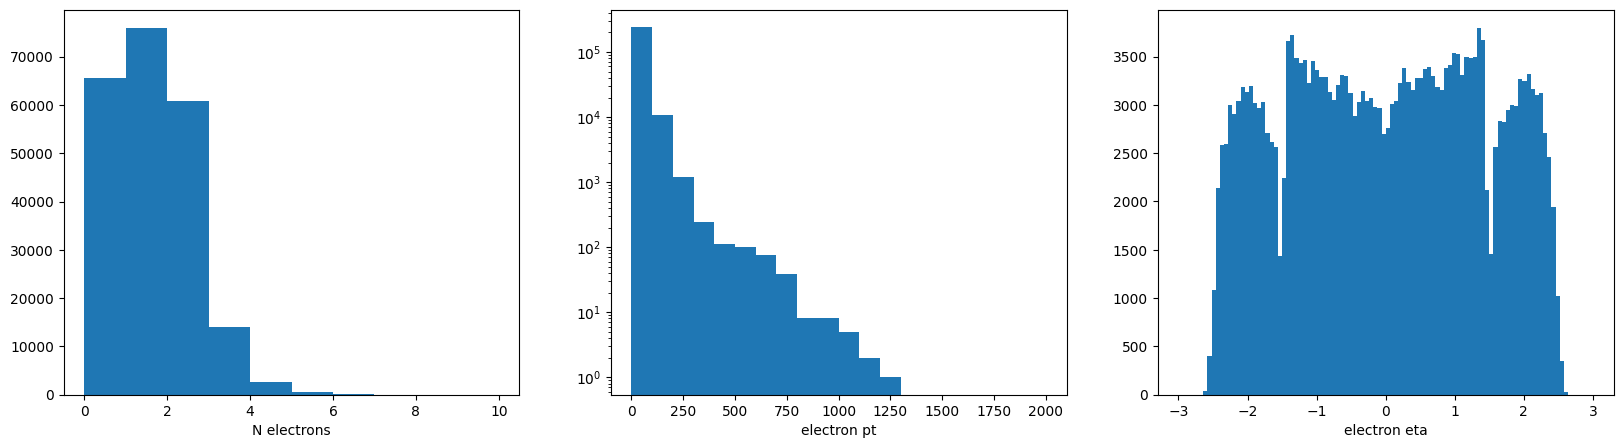

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

axes[0].hist(df['nElectron'], bins=10, range=(0,10))
axes[0].set_xlabel('N electrons')

axes[1].hist(ak.flatten(df['Electron_pt']), bins=20, range=(0,2000))
axes[1].set_xlabel('electron pt')
axes[1].set_yscale('log')

axes[2].hist(ak.flatten(df['Electron_eta']), bins=100, range=(-3,3))
axes[2].set_xlabel('electron eta')

Next we'll collect some of the electron information into an object (note that "Momentum4D" comes from [vector](https://vector.readthedocs.io/en/latest/))

In [55]:
electrons = ak.zip({
    'pt': df.Electron_pt,
    'phi': df.Electron_phi,
    'eta': df.Electron_eta,
    'mass': df.Electron_mass,
    'charge': df.Electron_charge,
}, with_name='Momentum4D')

Make some selection masks for precisely 2 electrons of opposite charge:

In [56]:
select_2e = (ak.num(electrons) == 2)
two_e = electrons[select_2e]

select_oppcharge = two_e[:,0].charge*two_e[:,1].charge == -1
two_e = two_e[select_oppcharge]

Calculate the invariant mass and plot

In [57]:
M = (two_e[:, 0] + two_e[:, 1]).mass

Text(0.5, 0, 'invariant mass [GeV]')

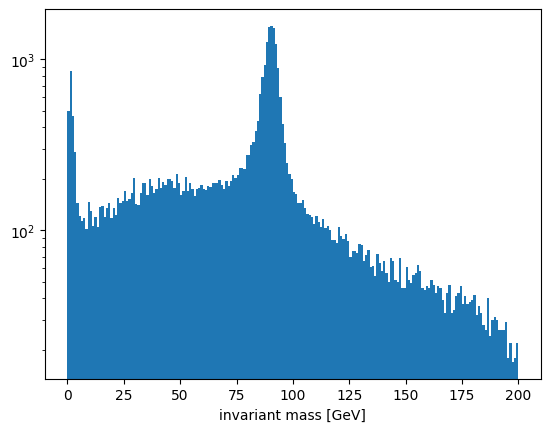

In [58]:
plt.hist(M, bins=200, range=(0,200))
plt.yscale('log')
plt.xlabel('invariant mass [GeV]')

These are some of the variables used for selection. See [here](https://cms-opendata-guide.web.cern.ch/analysis/selection/objects/electrons/) for some explanation. 

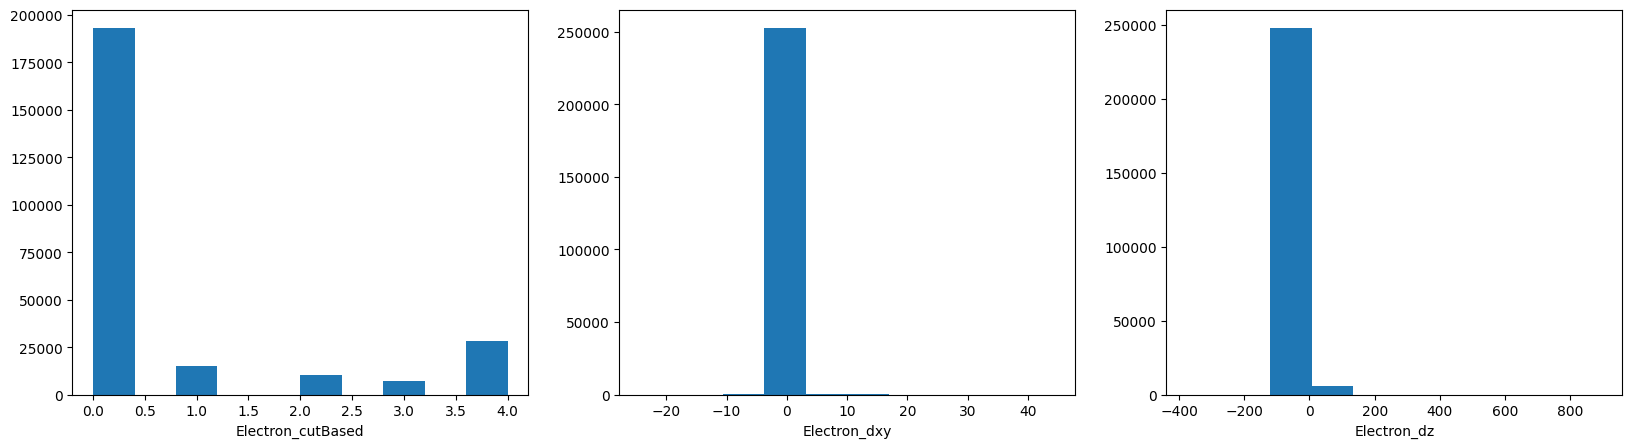

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

for i,v in enumerate(['Electron_cutBased', 'Electron_dxy', 'Electron_dz']):
    axes[i].hist(ak.flatten(df[v]))
    axes[i].set_xlabel(v)

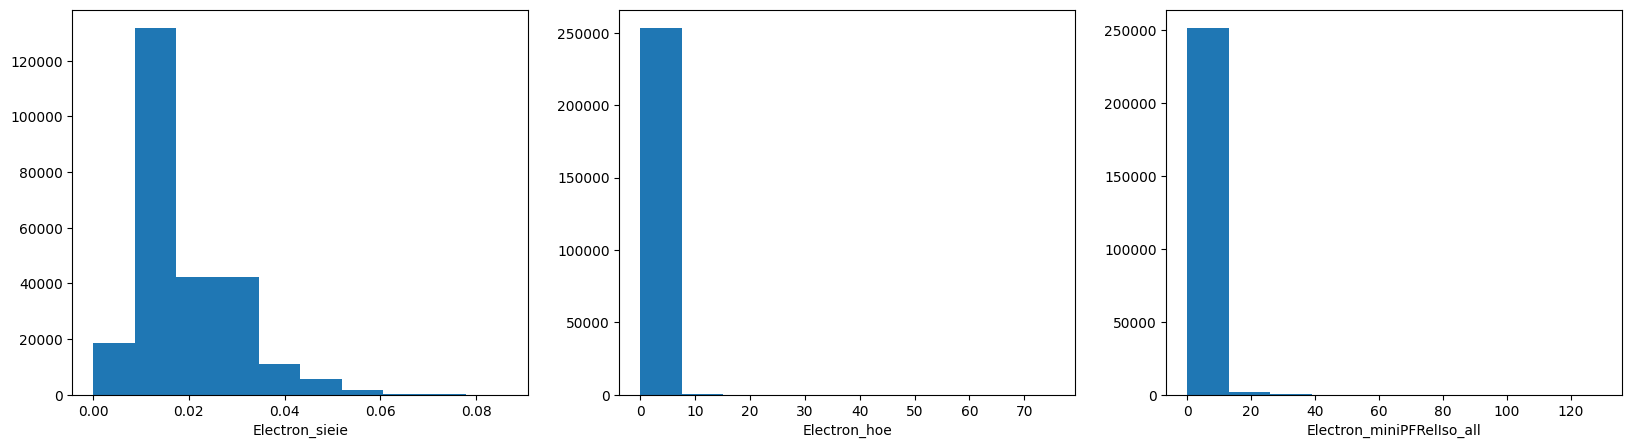

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

for i,v in enumerate(['Electron_sieie', 'Electron_hoe', 'Electron_miniPFRelIso_all']):
    axes[i].hist(ak.flatten(df[v]))
    axes[i].set_xlabel(v)

What if we only look at electrons in the barrel?

In [61]:
twoe_selection = (df['nElectron'] == 2)

df = df[twoe_selection]

In [62]:
eta_selection = ak.all(np.abs(df['Electron_eta']) < 1.479, axis=1)

df = df[eta_selection]

In [63]:
oppsign_selection = (ak.prod(df['Electron_charge'], axis=1) == -1)

df = df[oppsign_selection]

Make some other selections:

* Electron_sieie < 0.01
* Electron_hoe < 0.12

In [64]:
more_selections = (
    ak.all(df['Electron_sieie'] < 0.01, axis=1) &
    ak.all(df['Electron_hoe'] < 0.12, axis=1) 
)

df = df[more_selections]

In [65]:
len(df)

7789

In [66]:
electrons = ak.zip({
    'pt': df.Electron_pt,
    'phi': df.Electron_phi,
    'eta': df.Electron_eta,
    'mass': df.Electron_mass,
    'charge': df.Electron_charge,
}, with_name='Momentum4D')

In [67]:
M = (electrons[:, 0] + electrons[:, 1]).mass

Text(0.5, 0, 'invariant mass [GeV]')

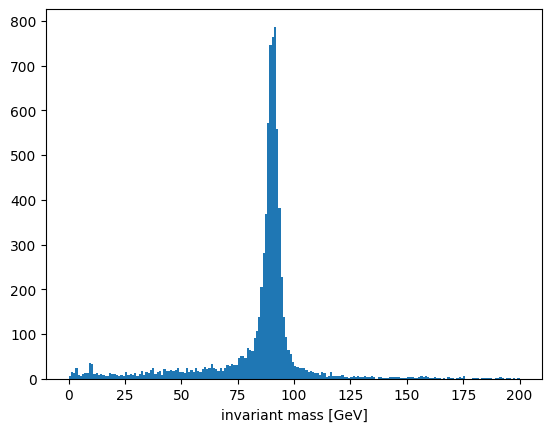

In [69]:
plt.hist(M, bins=200, range=(0,200))
plt.xlabel('invariant mass [GeV]')